In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

from sklearn.model_selection import train_test_split

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

class dateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Processing DateTime Data')
        print('Encoding....')
        retX = pd.DataFrame()

        for colname, col in X.iteritems():
            retX[colname+'_dayofweek'] = col.dt.dayofweek
            retX[colname+'_weekday'] = col.dt.weekday
            retX[colname+'_hour'] = col.dt.hour
            retX[colname+'_minute'] = col.dt.minute
            retX[colname+'_day'] = col.dt.day
            retX[colname+'_month'] = col.dt.month
            #retX[colname+'_year'] = col.dt.year
    
        return retX
    
def prepare_pipeline(ds):
    
    numeric_features = ds.select_dtypes(include=['float64']).columns.tolist()
    categorical_features = ds.select_dtypes(include=['object']).columns.tolist()
    date_features = ds.select_dtypes(include=[np.datetime64]).columns.tolist()
    
    cachedir = mkdtemp()
    memory = Memory(cachedir=cachedir, verbose=1)

    date_transformer = Pipeline(memory=memory, steps=[('dateEncoder', dateEncoder()), ('imputer', SimpleImputer(strategy='median', verbose=1))])
    numeric_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='median', verbose=1))])
    categorical_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing', verbose=1)),
                                                             ('onehot', OrdinalEncoder())])

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features)])

    proc = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return proc


class Anomaly_regressor(xgb.XGBRegressor):
    def __init__(self, nthread=-1, n_jobs=-1, max_depth=500, subsample=0.5, missing=None, colsample_bytree=0.5, 
                                    colsample_bylevel=0.5, reg_alpha=0.01, learning_rate=0.1, n_estimators=1000, random_state=123):

                                    
        super(Anomaly_regressor, self).__init__(nthread=nthread, n_jobs=n_jobs, max_depth=max_depth,missing=missing, subsample=subsample, \
                                                random_state=random_state, colsample_bytree=colsample_bytree, 
                                    colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha, learning_rate=learning_rate, n_estimators=n_estimators)
        self.preprocessor = None
        
    def fit(self, X, y):
        self.preprocessor = prepare_pipeline(X)
        print('Start Data pre-processing ...')
        self.preprocessor = self.preprocessor.fit(X)
        X = self.preprocessor.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=4891)
        super(Anomaly_regressor, self).fit(X_train, y_train, eval_set= ((X_train, y_train),(X_test, y_test)))
        return self
    
    def predict(self, X):
        return super(Anomaly_regressor, self).predict(self.preprocessor.transform(X))
         

In [2]:
#import pickle
#filename = "ano_regressor.pkl"
#ano_regressor = pickle.load(open(filename, 'rb'))

In [3]:
identifiers = ['user_id', 'request_id', 'target_recipient_id']
date_cols = ['date_user_created', 'date_request_submitted', 'date_request_received','date_request_transferred', \
             'first_attempt_date', 'first_success_date']
categorical = ['addr_country_code', 'addr_city', 'recipient_country_code', 'flag_personal_business', 'payment_type', \
               'payment_status', 'ccy_send', 'ccy_target', 'transfer_to_self', 'sending_bank_name',  'sending_bank_country',\
               'payment_reference_classification', 'device']

In [4]:
import pickle
filename = "ds.pkl"
ds = pickle.load(open(filename, 'rb'))

In [5]:
for colname in date_cols:
    ds[colname+'_dayofweek'] = ds[colname].dt.dayofweek
    ds[colname+'_weekday'] = ds[colname].dt.weekday
    ds[colname+'_hour'] = ds[colname].dt.hour
    ds[colname+'_minute'] = ds[colname].dt.minute
    ds[colname+'_day'] = ds[colname].dt.day
    ds[colname+'_month'] = ds[colname].dt.month

In [6]:
X = ds[[c for c in ds.columns.tolist() if c not in identifiers+['anomalous_score', 'anomalous']+date_cols]]
y = ds['anomalous_score'].values*5000

In [7]:
for c in X.columns.tolist():
    if X[c].dtype=='int64':
        print(c)
        X[c] = X[c].astype(np.float)

flag_transferred
date_user_created_dayofweek
date_user_created_weekday
date_user_created_hour
date_user_created_minute
date_user_created_day
date_user_created_month
date_request_submitted_dayofweek
date_request_submitted_weekday


C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


date_request_submitted_hour
date_request_submitted_minute
date_request_submitted_day
date_request_submitted_month


In [8]:
num = list()
cat = list()
for c in X.columns.tolist():
    if X[c].dtype=='float64':
        num.append(c)
    else:
        cat.append(c)

In [9]:
X = X[num+cat]

In [10]:
preprocessor = prepare_pipeline(X)
preprocessor.fit(X,y)

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmpf51qxnof'", use "location='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmpf51qxnof'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strategy='constant', verbose=1), 
      addr_country_code          addr_city recipient_country_code  \
0                   DEU             BERLIN                     GB   
1                   CAN            TORONTO                     US   
2                   GBR             BOLTON                     PT   
3                   GBR            SWINDON                     IN   
4                   FRA              PARIS                     GB   
5                   GBR          LIVERPOOL                     BG   
6                   USA             CORONA                     SE   
7                   GBR             LONDON                     PL   
8                   GBR             LONDON                     HU   
9         ..., 
array([-3.601116, ..., -7.2718

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=Memory(location=C:\Users\KHALID~1\AppData\Local\Temp\tmpf51qxnof\joblib),
     steps=[('imputer', SimpleImputer(copy=True, ...lf', 'sending_bank_name', 'sending_bank_country', 'payment_reference_classification', 'device'])]))])

In [11]:
procX = preprocessor.transform(X)
procX = pd.DataFrame(procX, columns=X.columns.tolist())

In [12]:
custs = ds.sort_values(['anomalous_score'])[['user_id', 'addr_country_code', 'addr_city', 'anomalous']].head(10)


In [13]:
anomaly_regressor = xgb.XGBRegressor(nthread=-1, n_jobs=-1, max_depth=500, subsample=0.5, missing=None, colsample_bytree=0.5, \
                                    colsample_bylevel=0.5, reg_alpha=0.01, learning_rate=0.1, n_estimators=1000, random_state=123)

                                    

In [14]:
anomaly_regressor.fit(procX, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=500,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=-1, objective='reg:linear', random_state=123,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [15]:
import shap

In [16]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(anomaly_regressor)

In [17]:
shap_values = explainer.shap_values(procX.iloc[0:10000,:])

In [18]:
# load JS visualization code to notebook
shap.initjs()

In [19]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# As an example of similarty, take the top anomalous transfer


In [24]:
ix = 2
instant = X.iloc[custs.index[ix],:]
#pd.DataFrame(dict(zip(ds.iloc[][[c for c in ds.columns.tolist() if c not in identifiers+['anomalous_score', 'anomalous']+date_cols]].index.values, ds.iloc[custs.index[ix]][[c for c in ds.columns.tolist() if c not in identifiers]].values)), index=[0])

In [25]:
instant

invoice_value                                                        11.102
invoice_value_cancel                                                    NaN
flag_transferred                                                          1
transfer_sequence                                                      7973
days_since_previous_req                                                   0
date_user_created_dayofweek                                               2
date_user_created_weekday                                                 2
date_user_created_hour                                                   11
date_user_created_minute                                                  4
date_user_created_day                                                    26
date_user_created_month                                                  11
date_request_submitted_dayofweek                                          3
date_request_submitted_weekday                                            3
date_request

# Anomalous

In [26]:
shap.force_plot(explainer.expected_value, shap_values[custs.index[ix],:], instant)

In [27]:
import matplotlib.pyplot as plt

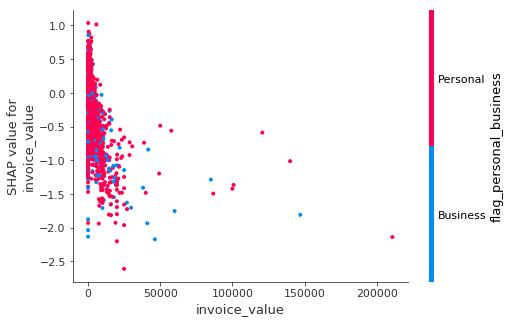

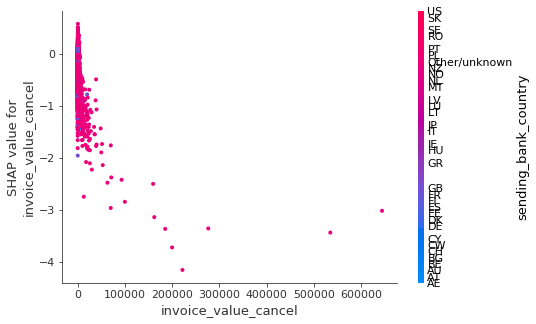

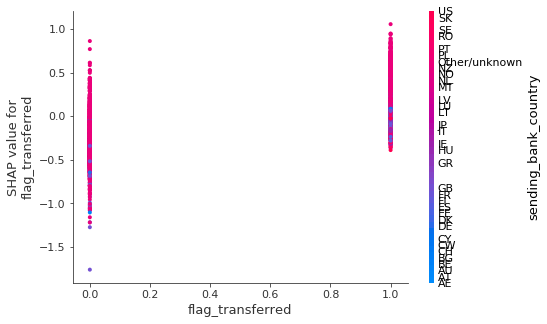

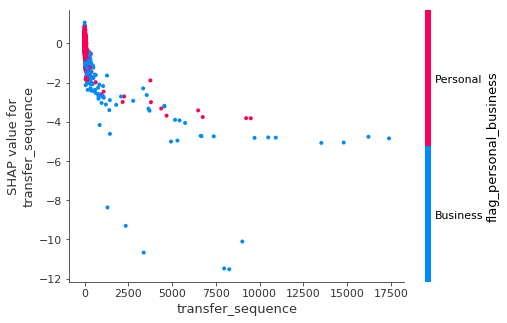

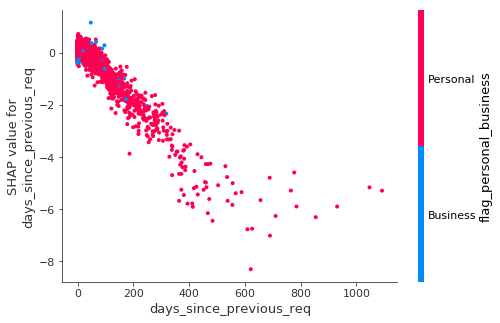

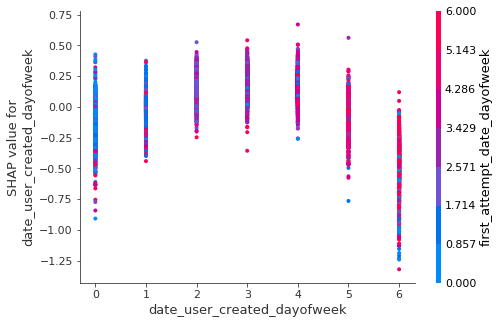

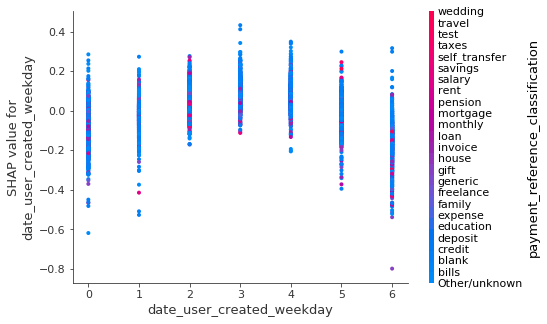

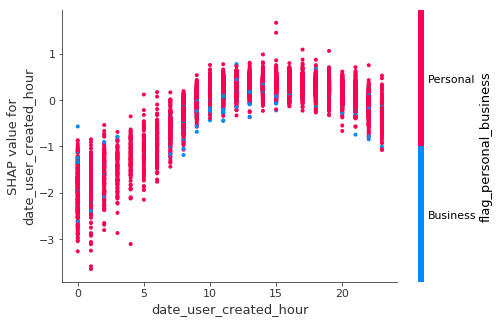

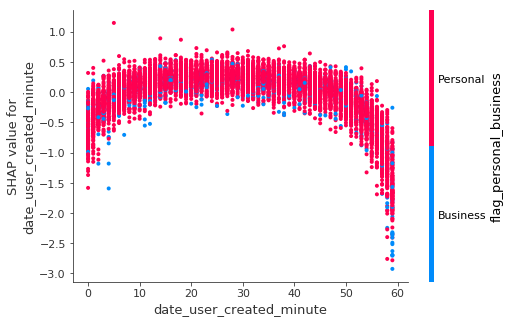

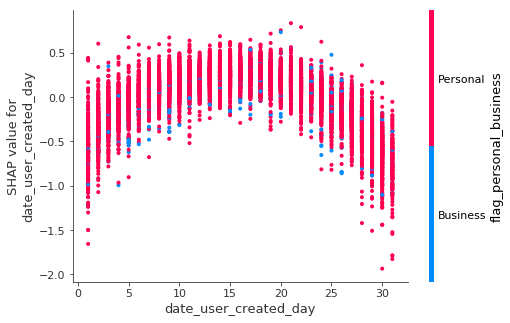

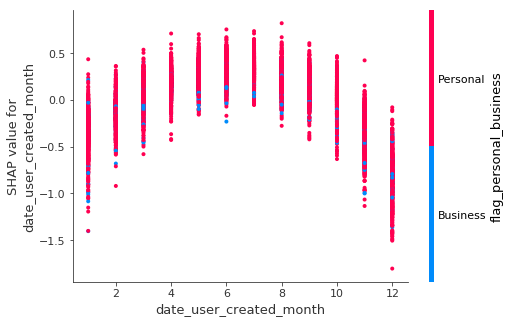

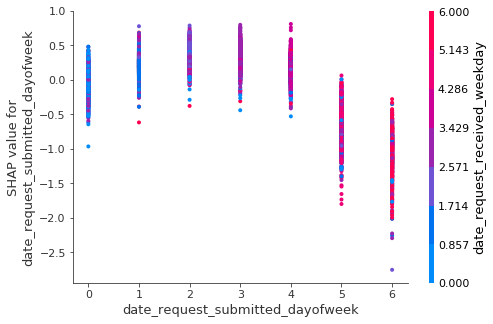

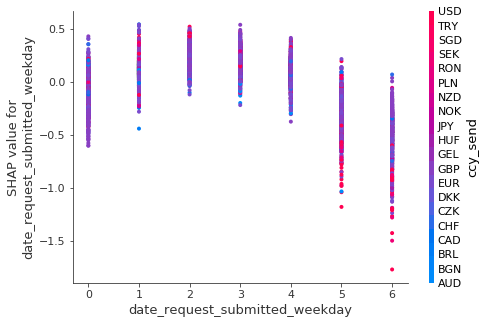

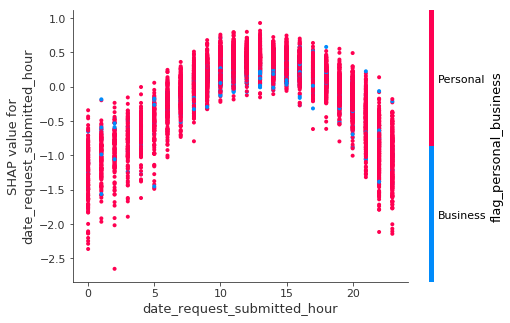

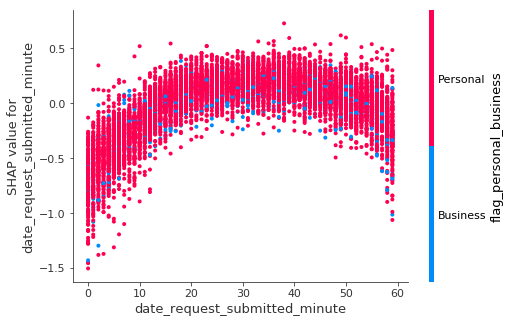

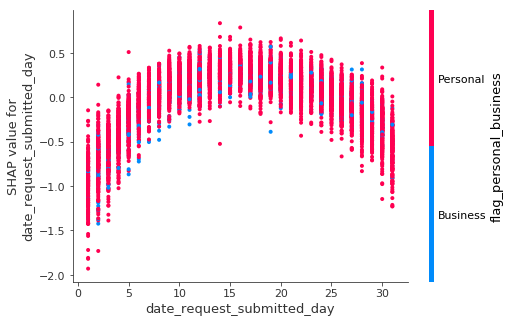

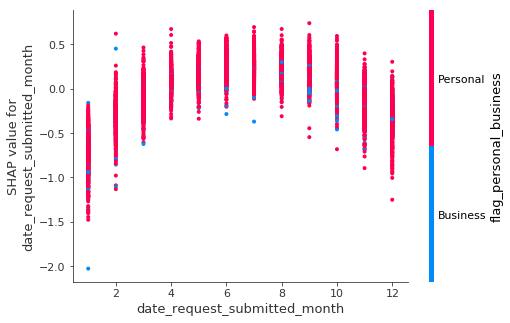

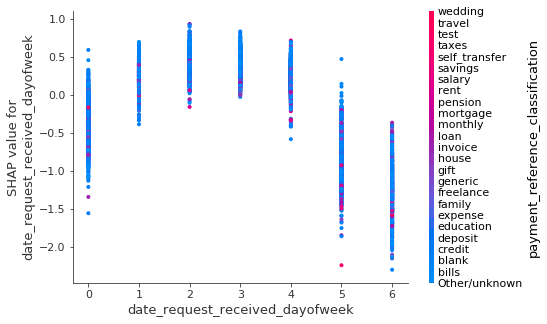

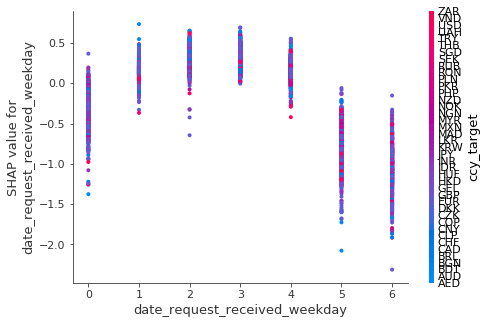

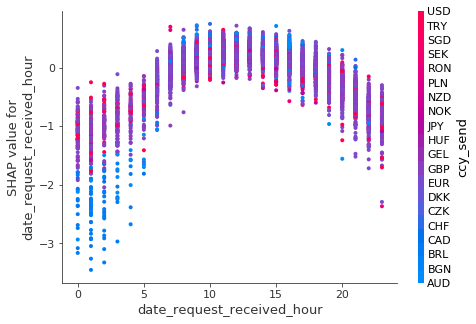

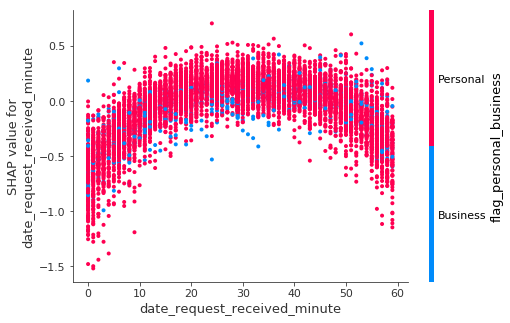

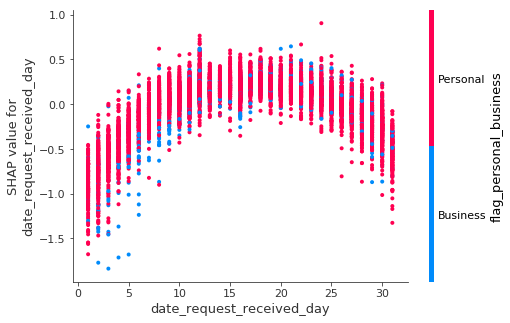

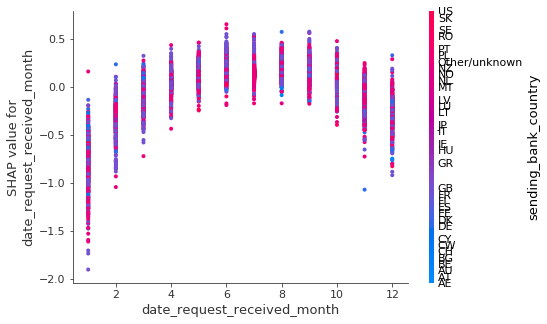

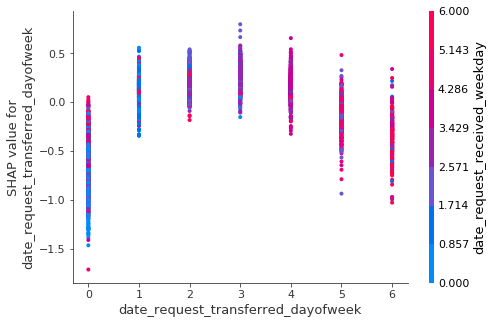

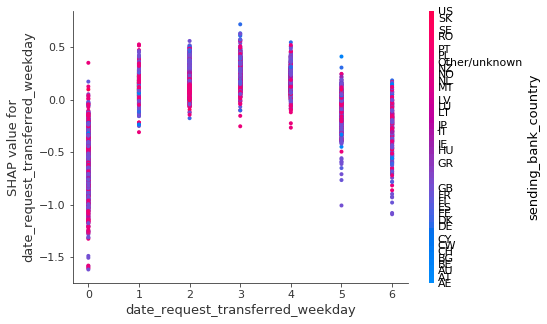

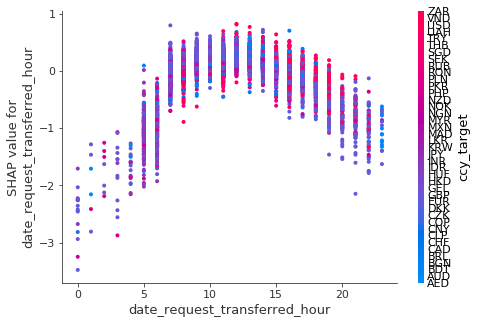

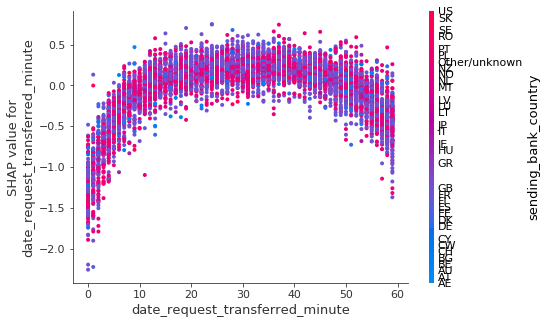

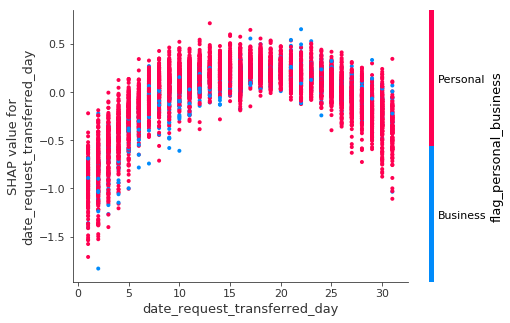

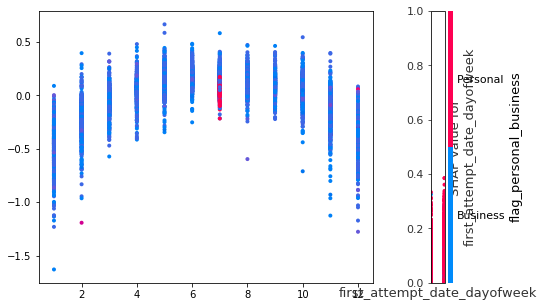

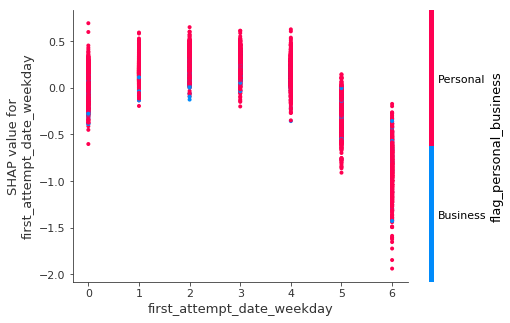

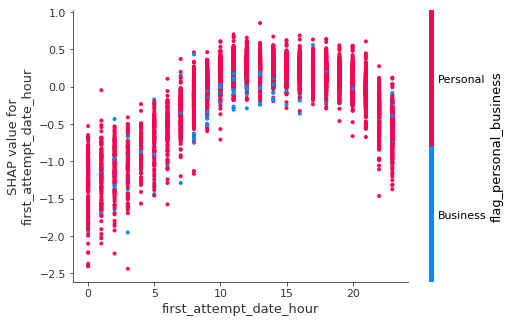

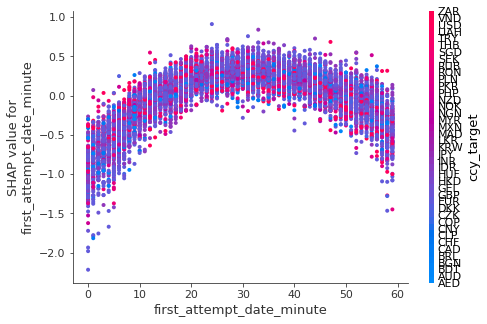

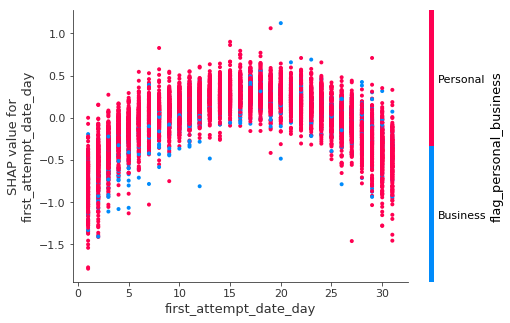

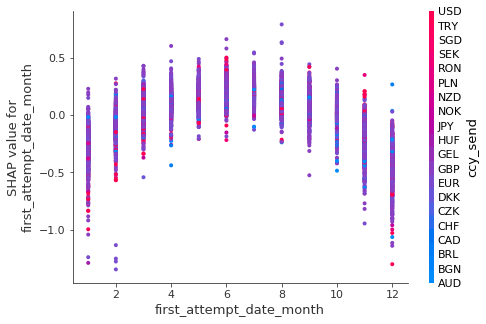

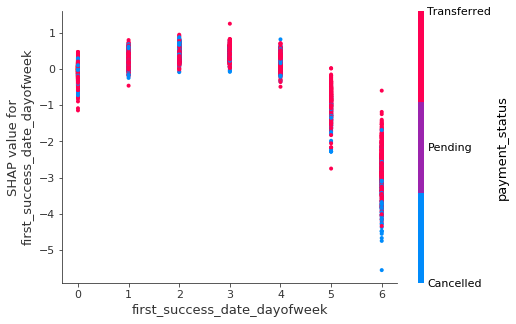

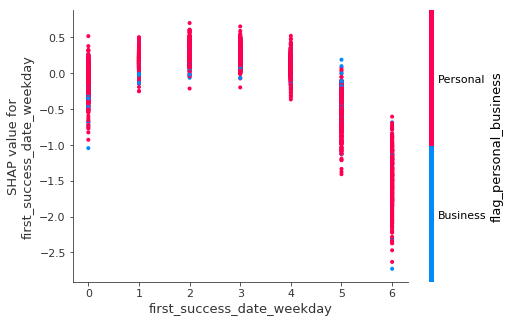

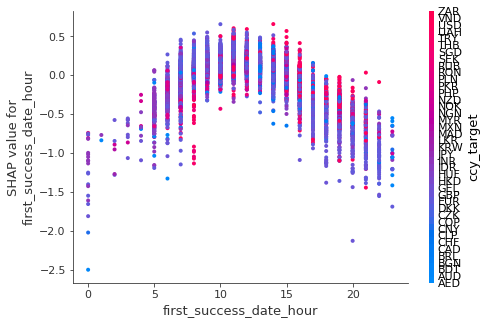

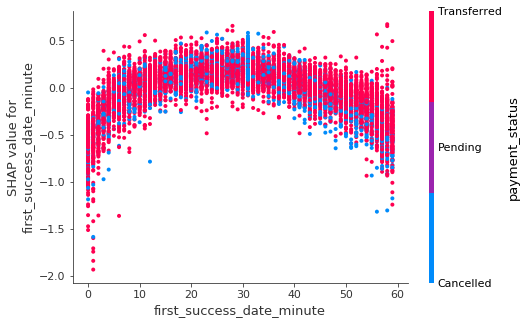

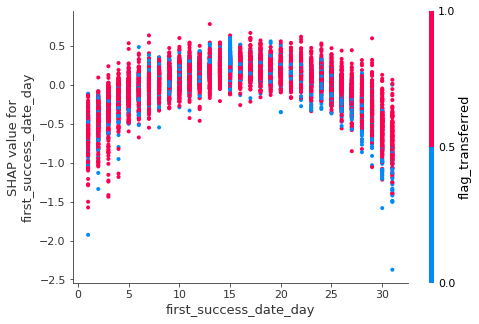

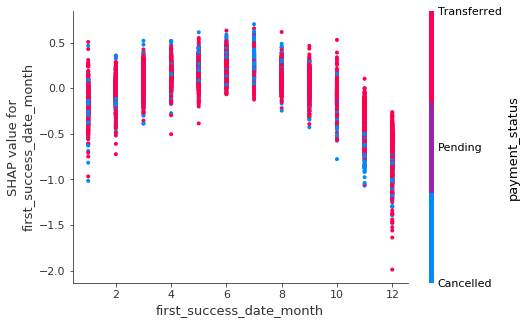

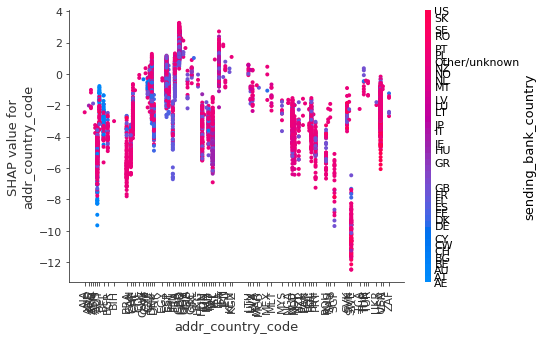

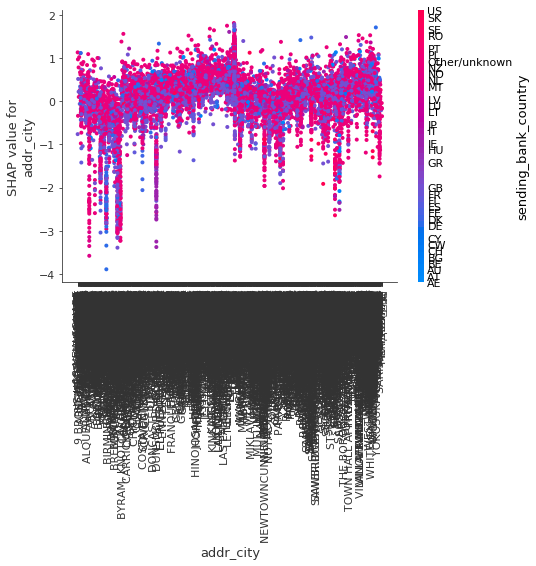

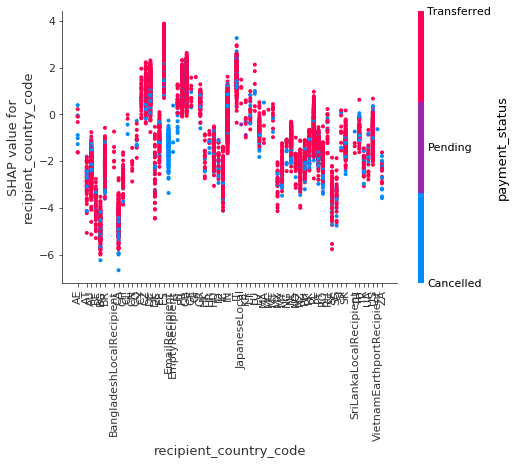

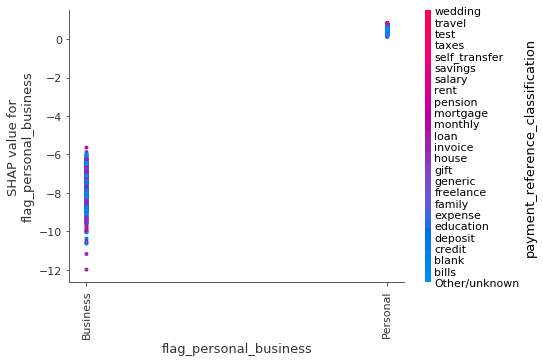

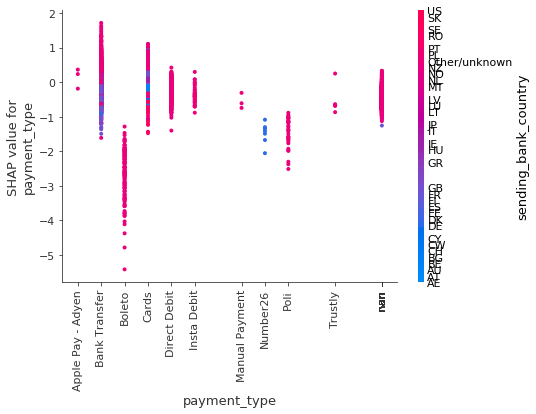

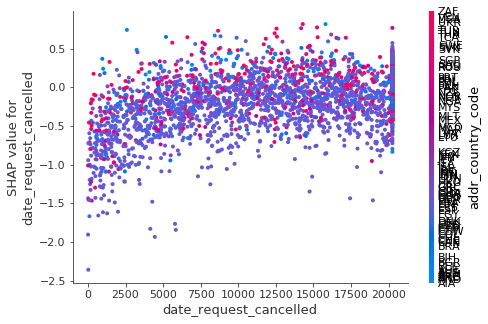

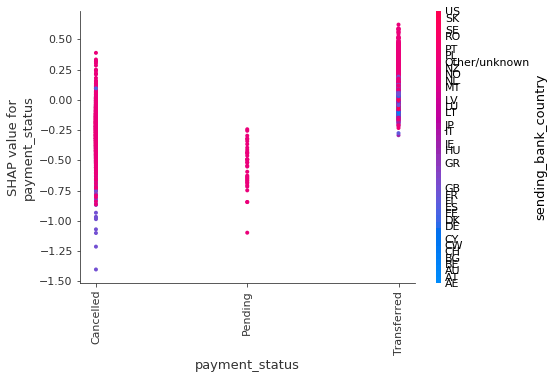

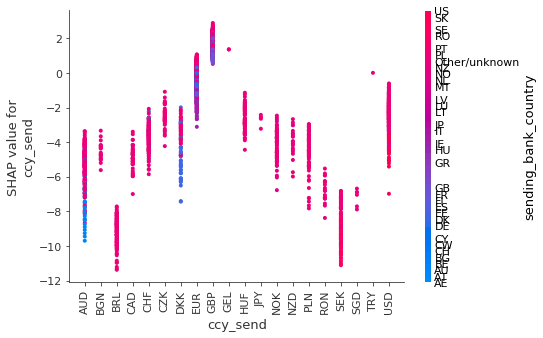

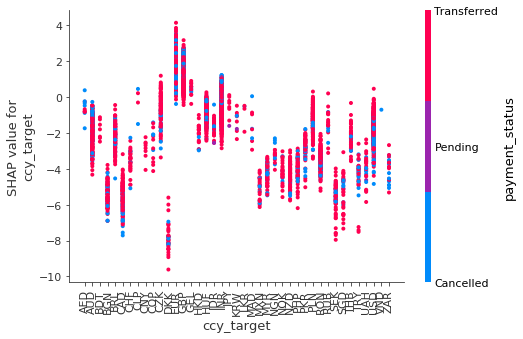

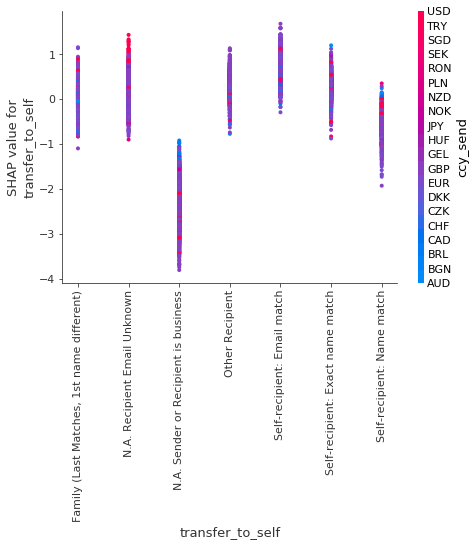

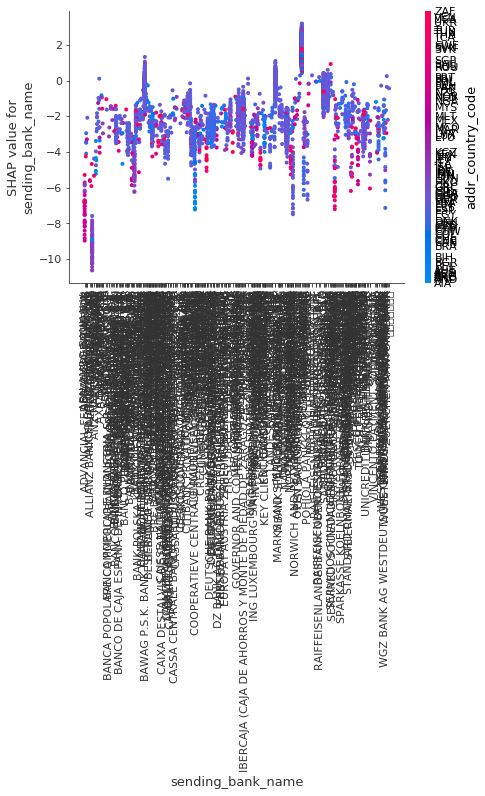

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\matplotlib\colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


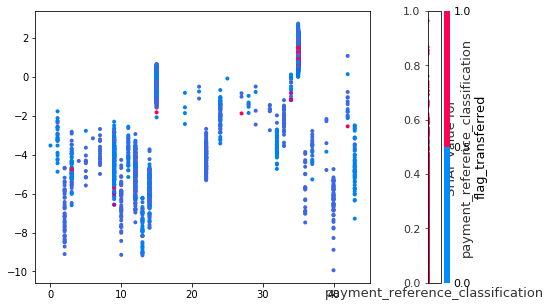

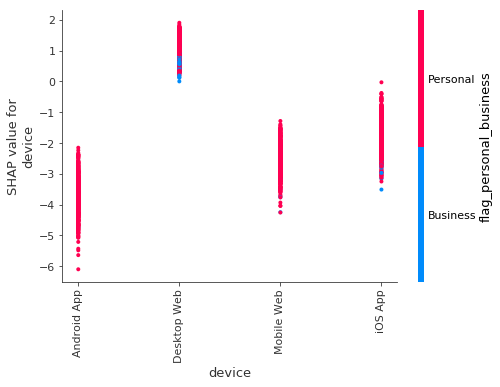

In [35]:
for c in X.columns.tolist():
    #plt.figure(figsize=(27,18))
    try:
        shap.dependence_plot(c, shap_values[:,:], procX.iloc[0:10000,:], display_features=X.loc[:,:])
        plt,show()
    except:
        pass

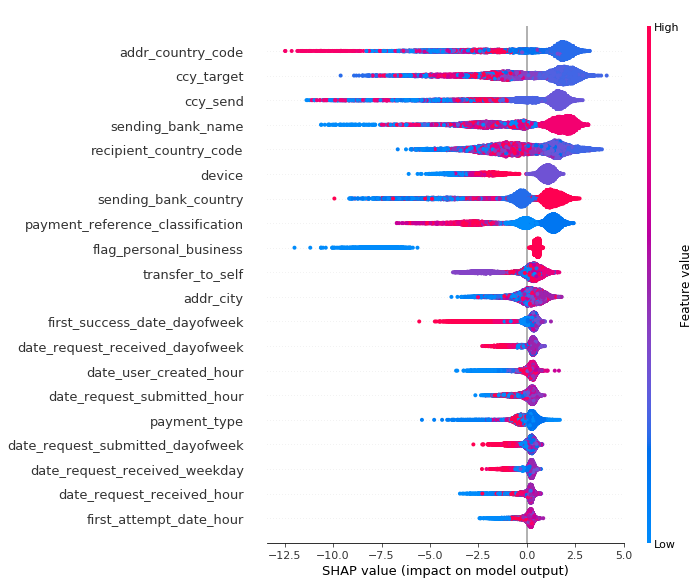

In [33]:
shap.summary_plot(shap_values, procX.iloc[0:10000,:])

In [ ]:
shap_interaction_values = shap.TreeExplainer(anomaly_regressor).shap_interaction_values(procX.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_interaction_values, procX.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_values, procX.iloc[0:10000,:], plot_type="bar")

In [ ]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), procX.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), procX.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()

# Not Anomalous

In [ ]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap_values[:1000,:].shape

In [ ]:
procX.iloc[:1000,:].shape

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], procX.iloc[:1000,:])

In [ ]:
import lime
import lime.lime_tabular

In [20]:
categorical_names = {}
for feature in cat:
    categorical_names[feature] = list(pd.unique(X[feature].dropna()))

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(procX.values, feature_names=procX.columns.tolist(), class_names=['Anomalous'], \
                                                   categorical_features=cat, categorical_names=categorical_names, verbose=True, mode='regression')

In [22]:
#shap_values[custs.index[ix],:], instant

In [23]:
def predx(x):
    if len(x.shape)==1:
        ds = pd.DataFrame(np.zeros((1,len(procX.columns.tolist()))),columns=procX.columns.tolist())
    else:
        ds = pd.DataFrame(np.zeros((x.shape[0],len(procX.columns.tolist()))),columns=procX.columns.tolist())
    for i in range(x.shape[0]):
        ds.iloc[i] = x[i]
    return anomaly_regressor.predict(ds)

In [27]:
exp = explainer.explain_instance(procX.iloc[custs.index[ix]].values, predx, num_features=10)

Intercept 5.495244745655528
Prediction_local [-7.2798109]
Right: -70.08753


In [28]:
exp.show_in_notebook(show_table=True)

In [29]:
categorical_names

{'addr_country_code': ['DEU',
  'CAN',
  'GBR',
  'FRA',
  'USA',
  'POL',
  'AUS',
  'SWE',
  'BRA',
  'IRL',
  'ESP',
  'BEL',
  'ROU',
  'NLD',
  'SVK',
  'IND',
  'AUT',
  'ITA',
  'FIN',
  'EST',
  'PRT',
  'CZE',
  'NZL',
  'BGR',
  'MYS',
  'LVA',
  'DNK',
  'NOR',
  'CHE',
  'HUN',
  'PHL',
  'ASM',
  'SGP',
  'IDN',
  'MLT',
  'RUS',
  'GRL',
  'SVN',
  'NGA',
  'GRC',
  'TUR',
  'IMN',
  'CYP',
  'ZAF',
  'THA',
  'VEN',
  'LTU',
  'CYM',
  'GIB',
  'AIA',
  'JPN',
  'TUN',
  'LUX',
  'ARE',
  'MAR',
  'JEY',
  'EGY',
  'PRI',
  'UKR',
  'GGY',
  'HKG',
  'ARG',
  'MCO',
  'BIH',
  'COL',
  'MEX',
  'ISL',
  'GHA',
  'AND',
  'SAU',
  'KGZ',
  'PAK',
  'CHL',
  'KEN',
  'PAN',
  'IOT',
  'TCA',
  'CUW',
  'GEO',
  'BGD',
  'MDA',
  'KOR',
  'SEN',
  'HRV',
  'SPM',
  'VGB',
  'QAT',
  'PER',
  'DOM',
  'ISR',
  'SYC',
  'VNM',
  'MTQ',
  'BLZ',
  'SLV',
  'ECU',
  'MUS',
  'DZA',
  'KWT',
  'CRI',
  'REU',
  'CHN',
  'SRB',
  'OMN',
  'GLP',
  'ERI',
  'TGO',
  'LKA',
  'MDG'